# IRON visualization part and Python execution example
This Notebook has two parts:
1. One that lets you visualize the hardware software comparison for the whole Image Registration application 
2. One shows an example execution for Mutual Information IP calls


## 1) Visualization
#### These two cells provide a visualization of the input images, how they looks like when compared, and how IRON register them compared against a pure software version

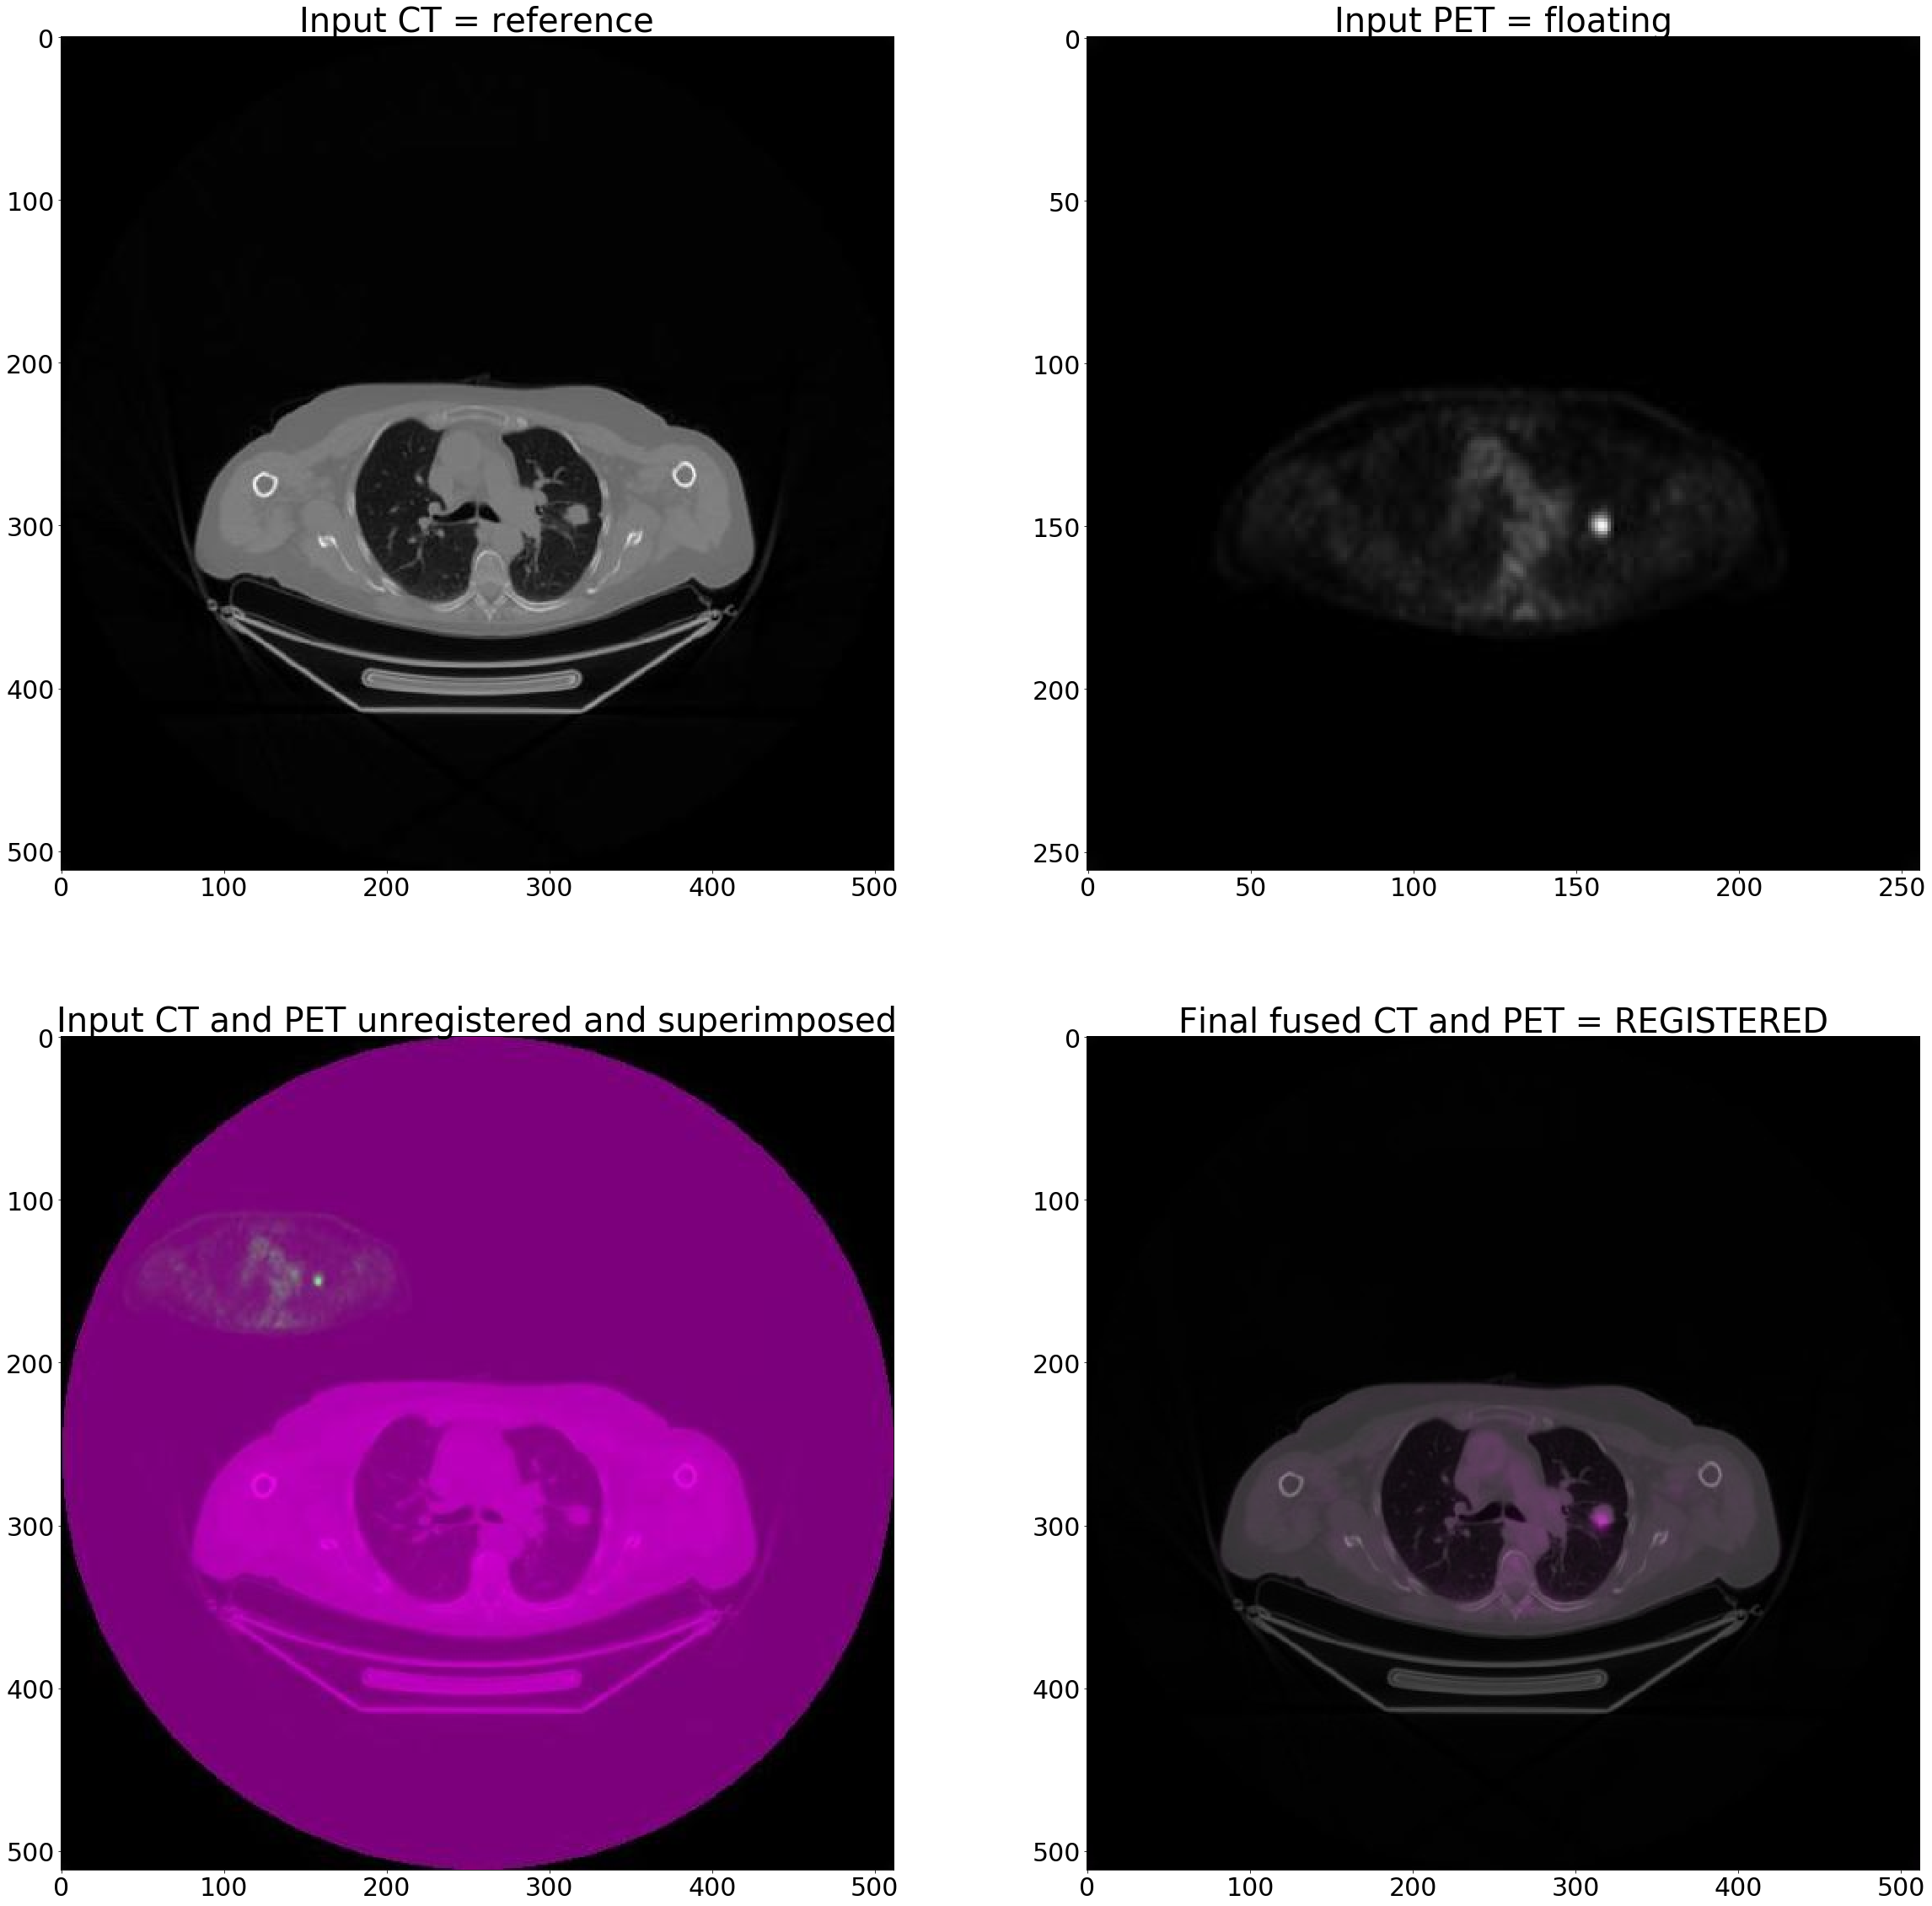

In [2]:
##########################################################################
# Notebook for creating the data visualization part of IRON project and
# python execution example of the hardware usage
##########################################################################

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
fig = plt.figure(figsize=(40,40))
a=fig.add_subplot(2,2,1)  # creating a matrix of 2x2 subplot for showing images
a.tick_params(axis = 'both', which = 'major', labelsize = 30) # setting dimension of axes values
a.set_title('Input CT = reference',fontsize=40) # setting title and text dimension to first subplot
img = mpimg.imread('../xohw19-iron/images/img2.jpeg') # loading the first image to be displayed
imgplot = plt.imshow(img) # plotting first image in the subplot created
a=fig.add_subplot(2,2,2)
a.set_title('Input PET = floating',fontsize=40)
a.tick_params(axis = 'both', which = 'major', labelsize = 30)
img1 = mpimg.imread('../xohw19-iron/images/img3.jpeg')
imgplot = plt.imshow(img1) # input PET image is smaller than input CT as shown below it is 256x256 instead of 512x512
                           # the difference is produced by the clinical acquisition procedure
a=fig.add_subplot(2,2,3)
a.set_title('Input CT and PET unregistered and superimposed',fontsize=40)
a.tick_params(axis = 'both', which = 'major', labelsize = 30)
img2 = mpimg.imread('../xohw19-iron/images/fused_pre.jpeg')
imgplot = plt.imshow(img2)
a=fig.add_subplot(2,2,4)
a.set_title('Final fused CT and PET = REGISTERED',fontsize=40)
a.tick_params(axis = 'both', which = 'major', labelsize = 30)
img3 = mpimg.imread('../xohw19-iron/images/img2img3-hw.jpeg')
imgplot = plt.imshow(img3)

The percentage of different pixels between sw and hw registration images is 4.8 %


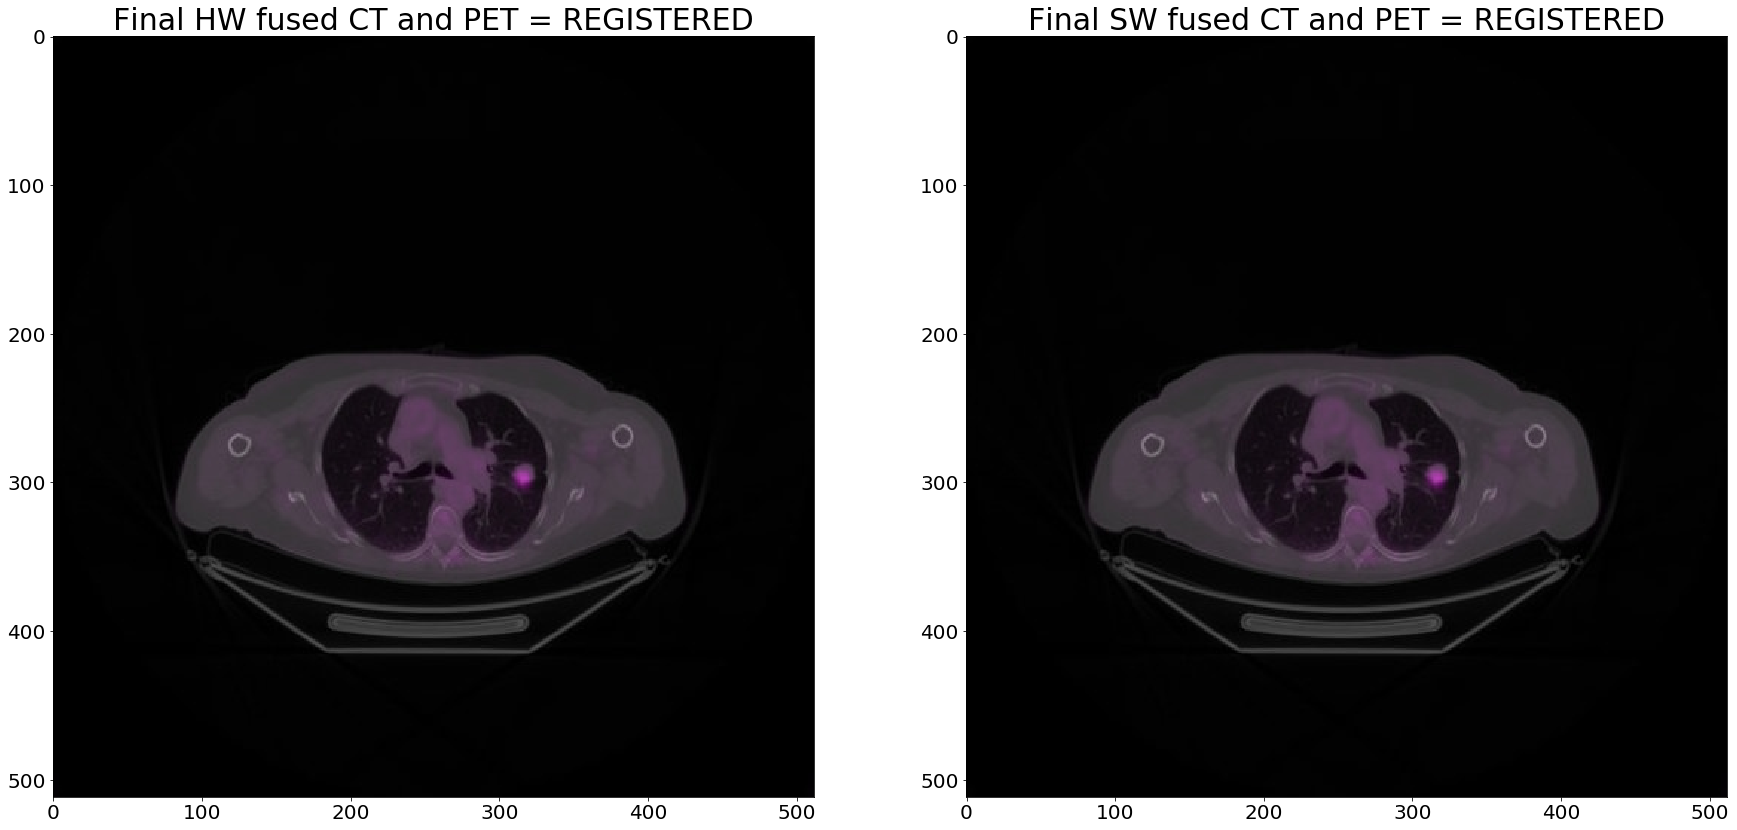

In [3]:
##############################
#Load sw and hw registered images
#comparison of different pixels between the two images
#visual comparison of hw registration and sw registration
##############################
import cv2
import numpy as np
a = cv2.imread("../xohw19-iron/images/img2img3-hw.jpeg")
b = cv2.imread("../xohw19-iron/images/img2img3-sw.jpeg")
c=0
for i in range (0, a.shape[0]):
    for j in range(0,a.shape[1]):
        if a[i,j,2]==b[i,j,2]: # comparing each pixel value of sw and hw registered images
            c=c+1
er=(a.shape[0]*a.shape[1]-c)/(a.shape[0]*a.shape[1])*100 # computing the percentage of pixels that differs between sw and ha registration
print("The percentage of different pixels between sw and hw registration images is",round(er,1),"%")
fig = plt.figure(figsize=(30,30))
a=fig.add_subplot(1,2,1)  # creating an array of 1x2 subplot for showing images
a.tick_params(axis = 'both', which = 'major', labelsize = 20) # setting dimension of axes values
a.set_title('Final HW fused CT and PET = REGISTERED',fontsize=30) # setting title and text dimension to first subplot
img = mpimg.imread('../xohw19-iron/images/img2img3-hw.jpeg') # loading the first image to be displayed
imgplot = plt.imshow(img) # plotting first image in the subplot created
a=fig.add_subplot(1,2,2)
a.set_title('Final SW fused CT and PET = REGISTERED',fontsize=30)
a.tick_params(axis = 'both', which = 'major', labelsize = 20)
img1 = mpimg.imread('../xohw19-iron/images/img2img3-sw.jpeg')
imgplot = plt.imshow(img1) 

## 2) Python exectuion example of the IRON IP for MI computation
To execute the hardware accelerator you need to
1. setup the environment: load the bitstream, choose the target frequency and initialize the drivers
2. Read the images and preprocess them
3. Prepare the memory for the hardware accelerator
4. Execute it and see the results

In [4]:
##############################
#Load the bitstream
#set the target frequency
#create the xlnk driver
##############################

from pynq import Overlay
from pynq import Xlnk
import numpy as np
########
#WARNING!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
########
# Remember to use the absolute path of the bitstream or follow PYNQ guide to load in default overlay
# 
iron = Overlay("../xohw19-iron/deploy/iron_wrapper.bit")
iron.download()
from pynq.ps import Clocks;
print("Previous Frequency "+str(Clocks.fclk2_mhz))
Clocks.fclk2_mhz = 250; 
print("New frequency "+str(Clocks.fclk2_mhz))
xlnk = Xlnk()

/usr/local/lib/python3.6/dist-packages/pynq/overlay.py:299: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)


Previous Frequency 149.9985
New frequency 249.9975


In [5]:
##############################
#read images in the iron repo
##############################

import cv2
dim = (512,512)
ref = cv2.imread('../xohw19-iron/images/img2.jpeg',0)
flt = cv2.imread('../xohw19-iron/images/img3.jpeg',0)
ref = cv2.resize(ref, dim)
flt = cv2.resize(flt, dim)

In [6]:
##############################
#Iron IP register mapping
# automatic generated with HLS IP generation
##############################
# 0x00 : Control signals
#         bit 0  - ap_start (Read/Write/COH)
#        bit 1  - ap_done (Read/COR)
#        bit 2  - ap_idle (Read)
#        bit 3  - ap_ready (Read)
#        bit 7  - auto_restart (Read/Write)
#        others - reserved
# 0x10 : Data signal of ref_V
#        bit 31~0 - ref_V[31:0] (Read/Write)
# 0x18 : Data signal of flt_V
#        bit 31~0 - flt_V[31:0] (Read/Write)
# 0x20 : Data signal of mutual_info
#        bit 31~0 - mutual_info[31:0] (Read)
# 0x24 : Control signal of mutual_info
#        bit 0  - mutual_info_ap_vld (Read/COR)
#        others - reserved
# (SC = Self Clear, COR = Clear on Read, TOW = Toggle on Write, COH = Clear on Handshake)
AP_CTRL_ADDR = 0x00
done_rdy = 0x6
start = 0x1
AP_REF_ADDR = 0x10
AP_FLT_ADDR = 0x18
AP_MI_ADDR = 0x20
AP_MI_CTRL = 0x24

bin(iron.mutual_information_m_0.read(AP_CTRL_ADDR))


'0b100'

In [7]:
##############################
# change  the input arrays into  the following formula the input images to test random data
#np.random.randint(0,255,512*512,np.uint8)
##############################
import time
#allocate a buffer and copy it
buff1 = xlnk.cma_alloc(512*512,0,"unsigned char")
xlnk.cma_memcopy(buff1, ref.data, 512*512)
buff2 = xlnk.cma_alloc(512*512,0,"unsigned char")
xlnk.cma_memcopy(buff2, flt.data, 512*512)

#write the  buffer address to the ip
iron.mutual_information_m_0.write(AP_REF_ADDR,xlnk.cma_get_phy_addr(buff1))
iron.mutual_information_m_0.write(AP_FLT_ADDR,xlnk.cma_get_phy_addr(buff2))

#start
t0 = time.clock()
iron.mutual_information_m_0.write(AP_CTRL_ADDR,start)
while iron.mutual_information_m_0.read(AP_CTRL_ADDR) != done_rdy :
    pass
t1 = time.clock()
delta = t1 - t0
print("IRON python exec time " +str(delta) + "s")

IRON python exec time 0.013440000000002783s


In [9]:
#Read if the is a valid value
iron.mutual_information_m_0.read(AP_MI_CTRL)

0

In [10]:
# read back the mutual information value
ret = iron.mutual_information_m_0.read(AP_MI_ADDR)
import struct
[x] = struct.unpack('f', ret.to_bytes(4,byteorder="little"))
x

0.6380596160888672

In [ ]:
#execute this cell to reset the memory buffers to for the PL
xlnk.xlnk_reset()
xlnk.cma_stats()